In [197]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import struct
import copy
from tqdm import tqdm
from PIL import Image

# 模型训练

In [3]:
#激活函数
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp=np.exp(x-x.max())
    return exp/exp.sum()

In [4]:
#构建网络类
class Net():
    def __init__(self,dimensions,distribution,activation,parameters=[]):
        self.dimensions = dimensions
        self.distribution = distribution
        self.parameters = parameters
        self.activation = activation
        
    def init_parameters_b(self,layer):
        dist=self.distribution[layer]['b']
        return np.random.rand(self.dimensions[layer])*(dist[1]-dist[0])+dist[0]
    
    def init_parameters_w(self,layer):
        dist=self.distribution[layer]['w']
        return np.random.rand(self.dimensions[layer-1],self.dimensions[layer])*(dist[1]-dist[0])+dist[0]
    
    def init_parameters(self):
        for i in range(len(self.distribution)):
            layer_parameter={}
            for j in self.distribution[i].keys():
                if j=='b':
                    layer_parameter['b']=self.init_parameters_b(i)
                    continue
                if j=='w':
                    layer_parameter['w']=self.init_parameters_w(i)
                    continue
            self.parameters.append(layer_parameter)
        return self.parameters
    
    def forward(self,img):
        A1=img+self.parameters[0]['b']
        Z1=self.activation[0](A1)
        A2=np.dot(Z1,self.parameters[1]['w'])+self.parameters[1]['b']
        Z2=self.activation[0](A2)
        A3=np.dot(Z2,self.parameters[2]['w'])+self.parameters[2]['b']
        Z3 = self.activation[1](A3)
        return Z3

In [5]:
#读取数据集
dataset_path=Path('./mnist')
train_img_path=dataset_path/'train-images-idx3-ubyte'
train_lab_path=dataset_path/'train-labels-idx1-ubyte'
test_img_path=dataset_path/'t10k-images-idx3-ubyte'
test_lab_path=dataset_path/'t10k-labels-idx1-ubyte'
train_num=50000
valid_num=10000
test_num=10000

In [6]:
with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255
    train_img=tmp_img[:train_num]
    valid_img=tmp_img[train_num:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255

with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab=np.fromfile(f,dtype=np.uint8)
    train_lab=tmp_lab[:train_num]
    valid_lab=tmp_lab[train_num:]
    
with open(test_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_lab=np.fromfile(f,dtype=np.uint8)

In [7]:
#可视化手写字体
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(train_lab[index]))
def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(valid_lab[index]))
def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(test_lab[index]))

label : 3


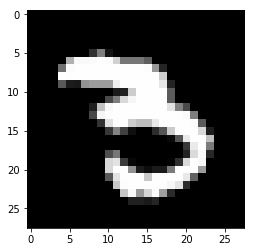

In [8]:
#测试show_train
show_train(np.random.randint(train_num))

label : 8


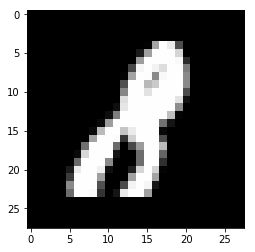

In [9]:
#测试show_test
show_test(np.random.randint(test_num))

In [10]:
#定义两个激活函数的导数
def d_softmax(data):
    sm=softmax(data)
    return np.diag(sm)-np.outer(sm,sm)

def d_tanh(data):
    return 1/(np.cosh(data))**2

In [11]:
#定义损失函数
def sqr_loss(img,lab):
    y_pred=net.forward(img)
    y=onehot[lab]
    diff=y-y_pred
    return np.dot(diff,diff)

In [12]:
#SGD,对每个样本都计算梯度,lambd为L2正则化参数
def backward(img,lab,parameters,lambd):
    A1=img+parameters[0]['b']
    Z1=activation[0](A1)
    A2=np.dot(Z1,parameters[1]['w'])+parameters[1]['b']
    Z2=activation[0](A2)
    A3=np.dot(Z2,parameters[2]['w'])+parameters[2]['b']
    Z3=activation[1](A3)
    
    diff=onehot[lab]-Z3
    act3 = np.dot(differential[activation[1]](A3),diff)#损失对A3的梯度
    act2 = differential[activation[0]](A2)*np.dot(parameters[2]['w'],act3)#损失对A2的梯度
    act1 = differential[activation[0]](A1)*np.dot(parameters[1]['w'],act2)#损失对A1的梯度
    grad_b2=-2*act3+2*lambd*parameters[2]['b']
    grad_w2=-2*np.outer(Z2,act3)+ lambd*parameters[2]['w']
    grad_b1=-2*act2+2*lambd*parameters[1]['b']
    grad_w1=-2*np.outer(Z1,act2)+ lambd*parameters[1]['w']
    grad_b0=-2*act1+ lambd*parameters[0]['b']
    
    return {'w2':grad_w2,'b2':grad_b2,'w1':grad_w1,'b1':grad_b1,'b0':grad_b0}

In [13]:
def valid_loss(parameters):
    loss_accu=0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(valid_img[img_i],valid_lab[img_i])
    return loss_accu/(valid_num/10000)
def valid_accuracy(parameters):
    correctlist=[net.forward(valid_img[img_i]).argmax()==valid_lab[img_i] for img_i in range(valid_num)]
    return correctlist.count(True)/len(correctlist)
def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(train_img[img_i],train_lab[img_i])
    return loss_accu/(train_num/10000)
def train_accuracy(parameters):
    correctlist=[net.forward(train_img[img_i]).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correctlist.count(True)/len(correctlist)

In [14]:
#计算梯度
def train_batch(current_batch,parameters,lambd):
    grad_accu=backward(train_img[current_batch*batch_size+0],train_lab[current_batch*batch_size+0],parameters,lambd)
    for img_i in range(1,batch_size):
        grad_tmp=backward(train_img[current_batch*batch_size+img_i],train_lab[current_batch*batch_size+img_i],parameters,lambd)
        for key in grad_accu.keys():
            grad_accu[key]+=grad_tmp[key]
    for key in grad_accu.keys():
        grad_accu[key]/=batch_size
    return grad_accu

In [15]:
#参数更新
def update_parameters(parameters,grad,learn_rate):
    parameter_tmp=copy.deepcopy(parameters)
    parameter_tmp[0]['b']-=learn_rate*grad['b0']
    parameter_tmp[1]['b']-=learn_rate*grad['b1']
    parameter_tmp[1]['w']-=learn_rate*grad['w1']
    parameter_tmp[2]['b']-=learn_rate*grad['b2']
    parameter_tmp[2]['w']-=learn_rate*grad['w2']
    return parameter_tmp

In [16]:
#学习率下降策略，加速收敛
def decay_lr(lr):
    if train_acscore>0.9:
        lr = lr/1.2
    elif train_acscore>0.7:
        lr = lr/1.1
    elif train_acscore>0.5:
        lr-=0.02
    return lr

In [17]:
#保存模型
def save_model(name,parameters):
    model_prameters_name = name+'.pkl'
    f = open(model_prameters_name, 'wb')
    pickle.dump(parameters, f)
    f.close()

In [18]:
current_epoch=0
train_loss_list=[]
valid_loss_list=[]
train_accu_list=[]
valid_accu_list=[]

In [68]:
#启动训练
differential={softmax:d_softmax,tanh:d_tanh}
onehot=np.identity(10)

#超参数
lr=0.25
epoch_num=10
lambd = 0.02
batch_size=100

train_acscore,valid_maxs = 0,0
#网络结构

dimensions=[28*28,100,10]
activation=[tanh,softmax]
distribution=[
    {'b':[0,0]},
    {'b':[0,0],'w':[-1,1]},
    {'b':[0,0],'w':[-1,1]}
]

net = Net(dimensions,distribution,activation,[])
net.init_parameters()
for epoch_ in tqdm(range(epoch_num)):
    lr = decay_lr(lr)
    for i in range(train_num//batch_size):
        if i%100==99:
            print('running batch {}/{}'.format(i+1,train_num//batch_size))
        grad_tmp = []
        grad_tmp=train_batch(i,net.parameters,lambd)
        net.parameters=update_parameters(net.parameters,grad_tmp,lr)
    current_epoch+=1
    train_acscore = train_accuracy(net.parameters)
    valid_acscore = valid_accuracy(net.parameters)
    print('acc on train {}, on valid {}'.format(train_acscore,valid_acscore))
    if valid_acscore>valid_maxs:
        save_model('Best_model',net.parameters) #保存验证集上表现最好的模型
        valid_maxs = valid_acscore
    train_loss_list.append(train_loss(net.parameters))
    train_accu_list.append(train_acscore)
    valid_loss_list.append(valid_loss(net.parameters))
    valid_accu_list.append(valid_acscore)

  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500
running batch 200/500
running batch 300/500
running batch 400/500
running batch 500/500
acc on train 0.87574, on valid 0.8933


 20%|██        | 1/5 [00:49<03:19, 49.89s/it]

running batch 100/500
running batch 200/500
running batch 300/500
running batch 400/500
running batch 500/500
acc on train 0.8802, on valid 0.8974


 40%|████      | 2/5 [01:39<02:28, 49.66s/it]

running batch 100/500
running batch 200/500
running batch 300/500
running batch 400/500
running batch 500/500
acc on train 0.88114, on valid 0.8984


 60%|██████    | 3/5 [02:28<01:39, 49.51s/it]

running batch 100/500
running batch 200/500
running batch 300/500
running batch 400/500
running batch 500/500
acc on train 0.88148, on valid 0.8982


 80%|████████  | 4/5 [03:17<00:49, 49.34s/it]

running batch 100/500
running batch 200/500
running batch 300/500
running batch 400/500
running batch 500/500
acc on train 0.88224, on valid 0.8987


100%|██████████| 5/5 [04:06<00:00, 49.35s/it]


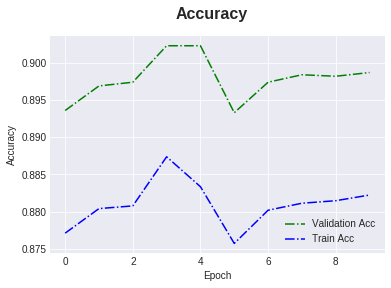

In [69]:
#可视化acc
plt.clf()
plt.plot(valid_accu_list, c='g', label='Validation Acc',linestyle = '-.')
plt.plot(train_accu_list, c='b', label='Train Acc',linestyle = '-.')
plt.legend()
plt.suptitle('Accuracy', fontsize=16, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('acc.png',dpi = 200)

<Figure size 432x288 with 0 Axes>

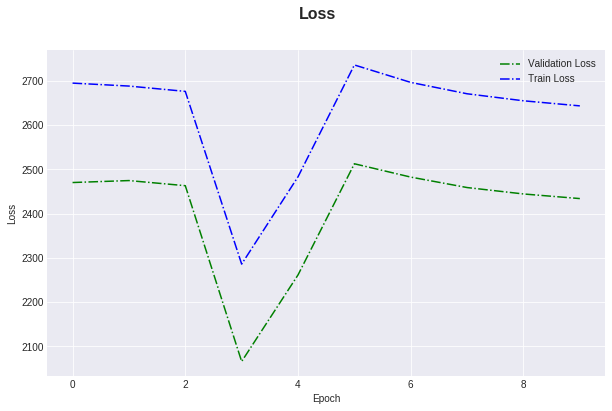

In [70]:
#可视化acc
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(valid_loss_list, c='g', label='Validation Loss',linestyle = '-.')
plt.plot(train_loss_list, c='b', label='Train Loss',linestyle = '-.')
plt.legend()
plt.suptitle('Loss', fontsize=16, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.png',dpi = 200)

In [103]:
#用于测试模型测试集上表现
f = open('Best_model.pkl', 'rb') #加载最优模型
param = pickle.load(f)
f.close

<function BufferedReader.close>

label : 5
predict:5


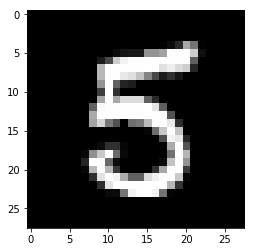

In [105]:
test_index = np.random.randint(1000)
show_test(test_index)
predict_result = forward(test_img[test_index], param)
print("predict:{}".format(predict_result.argmax()))

# 网格搜索超参数

In [53]:
#定义一些备选策略
strategydic = {
    'strategy1':{
        'dimensions':[28*28,512,10],
        'lr':0.1,
        'lambda':0.01
    },
    'strategy2':{
        'dimensions':[28*28,256,10],
        'lr':0.15,
        'lambda':0.01
    },
    'strategy3':{
        'dimensions':[28*28,100,10],
        'lr':0.15,
        'lambda':0.02
    },
    'strategy4':{
        'dimensions':[28*28,100,10],
        'lr':0.25,
        'lambda':0.05
    },
    'strategy5':{
        'dimensions':[28*28,50,10],
        'lr':0.25,
        'lambda':0.05
    },
    'strategy6':{
        'dimensions':[28*28,50,10],
        'lr':0.2,
        'lambda':0.02
    },
    'strategy7':{
        'dimensions':[28*28,50,10],
        'lr':0.15,
        'lambda':0.01
    },
    'strategy8':{
        'dimensions':[28*28,150,10],
        'lr':0.25,
        'lambda':0.03
    }
}
current_epoch=0
searchtrain_accu_list=[]
searchvalid_accu_list=[]
bestperformance = {}
#超参数
epoch_num=5
batch_size=100
for strategy in strategydic:
    dim = strategydic[strategy]['dimensions']
    lr = strategydic[strategy]['lr']
    lambd = strategydic[strategy]['lambda']
    trainaclist = []
    validaclist = []
    train_acscore,valid_maxs = 0,0
    net = Net(dim,distribution,activation,[])
    net.init_parameters()
    for epoch_ in tqdm(range(epoch_num)):
        lr = decay_lr(lr)
        for i in range(train_num//batch_size):
            if i%100==99:
                print('running batch {}/{}, current strategy {}'.format(i+1,train_num//batch_size,strategy))
            grad_tmp = []
            grad_tmp=train_batch(i,net.parameters,lambd)
            net.parameters=update_parameters(net.parameters,grad_tmp,lr)
        current_epoch+=1
        train_acscore = train_accuracy(net.parameters)
        valid_acscore = valid_accuracy(net.parameters)
        print('acc on train {}, on valid {}'.format(train_acscore,valid_acscore))
        if valid_acscore>valid_maxs:
            save_model('Best_model_'+strategy,net.parameters) #保存验证集上表现最好的模型
            valid_maxs = valid_acscore
        trainaclist.append(train_acscore)
        validaclist.append(valid_acscore)
    searchtrain_accu_list.append(trainaclist)
    searchvalid_accu_list.append(validaclist)
    bestperformance[strategy] = {}
    bestperformance[strategy]['train'] = max(trainaclist)
    bestperformance[strategy]['valid'] = max(validaclist)

  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy1
running batch 200/500, current strategy strategy1
running batch 300/500, current strategy strategy1
running batch 400/500, current strategy strategy1
running batch 500/500, current strategy strategy1


 20%|██        | 1/5 [01:34<06:19, 94.84s/it]

acc on train 0.69486, on valid 0.7063
running batch 100/500, current strategy strategy1
running batch 200/500, current strategy strategy1
running batch 300/500, current strategy strategy1
running batch 400/500, current strategy strategy1
running batch 500/500, current strategy strategy1


 40%|████      | 2/5 [03:09<04:43, 94.65s/it]

acc on train 0.8395, on valid 0.8461
running batch 100/500, current strategy strategy1
running batch 200/500, current strategy strategy1
running batch 300/500, current strategy strategy1
running batch 400/500, current strategy strategy1
running batch 500/500, current strategy strategy1


 60%|██████    | 3/5 [04:44<03:09, 94.66s/it]

acc on train 0.90686, on valid 0.9147
running batch 100/500, current strategy strategy1
running batch 200/500, current strategy strategy1
running batch 300/500, current strategy strategy1
running batch 400/500, current strategy strategy1
running batch 500/500, current strategy strategy1


 80%|████████  | 4/5 [06:18<01:34, 94.58s/it]

acc on train 0.91596, on valid 0.9223
running batch 100/500, current strategy strategy1
running batch 200/500, current strategy strategy1
running batch 300/500, current strategy strategy1
running batch 400/500, current strategy strategy1
running batch 500/500, current strategy strategy1


100%|██████████| 5/5 [07:52<00:00, 94.60s/it]


acc on train 0.91638, on valid 0.9229


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy2
running batch 200/500, current strategy strategy2
running batch 300/500, current strategy strategy2
running batch 400/500, current strategy strategy2
running batch 500/500, current strategy strategy2


 20%|██        | 1/5 [01:07<04:28, 67.14s/it]

acc on train 0.66598, on valid 0.6741
running batch 100/500, current strategy strategy2
running batch 200/500, current strategy strategy2
running batch 300/500, current strategy strategy2
running batch 400/500, current strategy strategy2
running batch 500/500, current strategy strategy2


 40%|████      | 2/5 [02:14<03:22, 67.45s/it]

acc on train 0.80304, on valid 0.8181
running batch 100/500, current strategy strategy2
running batch 200/500, current strategy strategy2
running batch 300/500, current strategy strategy2
running batch 400/500, current strategy strategy2
running batch 500/500, current strategy strategy2


 60%|██████    | 3/5 [03:22<02:15, 67.68s/it]

acc on train 0.90268, on valid 0.9151
running batch 100/500, current strategy strategy2
running batch 200/500, current strategy strategy2
running batch 300/500, current strategy strategy2
running batch 400/500, current strategy strategy2
running batch 500/500, current strategy strategy2


 80%|████████  | 4/5 [04:30<01:07, 67.81s/it]

acc on train 0.90164, on valid 0.9133
running batch 100/500, current strategy strategy2
running batch 200/500, current strategy strategy2
running batch 300/500, current strategy strategy2
running batch 400/500, current strategy strategy2
running batch 500/500, current strategy strategy2


100%|██████████| 5/5 [05:38<00:00, 67.69s/it]


acc on train 0.90044, on valid 0.9127


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy3
running batch 200/500, current strategy strategy3
running batch 300/500, current strategy strategy3
running batch 400/500, current strategy strategy3
running batch 500/500, current strategy strategy3


 20%|██        | 1/5 [00:45<03:01, 45.48s/it]

acc on train 0.8385, on valid 0.8562
running batch 100/500, current strategy strategy3
running batch 200/500, current strategy strategy3
running batch 300/500, current strategy strategy3
running batch 400/500, current strategy strategy3
running batch 500/500, current strategy strategy3


 40%|████      | 2/5 [01:31<02:16, 45.63s/it]

acc on train 0.88026, on valid 0.8949
running batch 100/500, current strategy strategy3
running batch 200/500, current strategy strategy3
running batch 300/500, current strategy strategy3
running batch 400/500, current strategy strategy3
running batch 500/500, current strategy strategy3


 60%|██████    | 3/5 [02:16<01:31, 45.55s/it]

acc on train 0.88208, on valid 0.8981
running batch 100/500, current strategy strategy3
running batch 200/500, current strategy strategy3
running batch 300/500, current strategy strategy3
running batch 400/500, current strategy strategy3
running batch 500/500, current strategy strategy3


 80%|████████  | 4/5 [03:02<00:45, 45.53s/it]

acc on train 0.88228, on valid 0.8971
running batch 100/500, current strategy strategy3
running batch 200/500, current strategy strategy3
running batch 300/500, current strategy strategy3
running batch 400/500, current strategy strategy3
running batch 500/500, current strategy strategy3


100%|██████████| 5/5 [03:47<00:00, 45.49s/it]


acc on train 0.88262, on valid 0.8972


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy4
running batch 200/500, current strategy strategy4
running batch 300/500, current strategy strategy4
running batch 400/500, current strategy strategy4
running batch 500/500, current strategy strategy4


 20%|██        | 1/5 [00:44<02:59, 44.99s/it]

acc on train 0.73756, on valid 0.7558
running batch 100/500, current strategy strategy4
running batch 200/500, current strategy strategy4
running batch 300/500, current strategy strategy4
running batch 400/500, current strategy strategy4
running batch 500/500, current strategy strategy4


 40%|████      | 2/5 [01:29<02:14, 44.88s/it]

acc on train 0.71738, on valid 0.735
running batch 100/500, current strategy strategy4
running batch 200/500, current strategy strategy4
running batch 300/500, current strategy strategy4
running batch 400/500, current strategy strategy4
running batch 500/500, current strategy strategy4


 60%|██████    | 3/5 [02:14<01:29, 44.86s/it]

acc on train 0.71706, on valid 0.7333
running batch 100/500, current strategy strategy4
running batch 200/500, current strategy strategy4
running batch 300/500, current strategy strategy4
running batch 400/500, current strategy strategy4
running batch 500/500, current strategy strategy4


 80%|████████  | 4/5 [02:59<00:45, 45.03s/it]

acc on train 0.7177, on valid 0.734
running batch 100/500, current strategy strategy4
running batch 200/500, current strategy strategy4
running batch 300/500, current strategy strategy4
running batch 400/500, current strategy strategy4
running batch 500/500, current strategy strategy4


100%|██████████| 5/5 [03:45<00:00, 45.02s/it]


acc on train 0.719, on valid 0.7346


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy5
running batch 200/500, current strategy strategy5
running batch 300/500, current strategy strategy5
running batch 400/500, current strategy strategy5
running batch 500/500, current strategy strategy5


 20%|██        | 1/5 [00:30<02:03, 30.91s/it]

acc on train 0.65562, on valid 0.6647
running batch 100/500, current strategy strategy5
running batch 200/500, current strategy strategy5
running batch 300/500, current strategy strategy5
running batch 400/500, current strategy strategy5
running batch 500/500, current strategy strategy5


 40%|████      | 2/5 [01:01<01:32, 30.77s/it]

acc on train 0.64954, on valid 0.6596
running batch 100/500, current strategy strategy5
running batch 200/500, current strategy strategy5
running batch 300/500, current strategy strategy5
running batch 400/500, current strategy strategy5
running batch 500/500, current strategy strategy5


 60%|██████    | 3/5 [01:32<01:01, 30.75s/it]

acc on train 0.64994, on valid 0.6595
running batch 100/500, current strategy strategy5
running batch 200/500, current strategy strategy5
running batch 300/500, current strategy strategy5
running batch 400/500, current strategy strategy5
running batch 500/500, current strategy strategy5


 80%|████████  | 4/5 [02:02<00:30, 30.72s/it]

acc on train 0.65042, on valid 0.6602
running batch 100/500, current strategy strategy5
running batch 200/500, current strategy strategy5
running batch 300/500, current strategy strategy5
running batch 400/500, current strategy strategy5
running batch 500/500, current strategy strategy5


100%|██████████| 5/5 [02:33<00:00, 30.74s/it]


acc on train 0.65066, on valid 0.6598


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy6
running batch 200/500, current strategy strategy6
running batch 300/500, current strategy strategy6
running batch 400/500, current strategy strategy6
running batch 500/500, current strategy strategy6


 20%|██        | 1/5 [00:30<02:03, 30.78s/it]

acc on train 0.86678, on valid 0.8853
running batch 100/500, current strategy strategy6
running batch 200/500, current strategy strategy6
running batch 300/500, current strategy strategy6
running batch 400/500, current strategy strategy6
running batch 500/500, current strategy strategy6


 40%|████      | 2/5 [01:01<01:32, 30.85s/it]

acc on train 0.88078, on valid 0.897
running batch 100/500, current strategy strategy6
running batch 200/500, current strategy strategy6
running batch 300/500, current strategy strategy6
running batch 400/500, current strategy strategy6
running batch 500/500, current strategy strategy6


 60%|██████    | 3/5 [01:32<01:01, 30.76s/it]

acc on train 0.88162, on valid 0.8979
running batch 100/500, current strategy strategy6
running batch 200/500, current strategy strategy6
running batch 300/500, current strategy strategy6
running batch 400/500, current strategy strategy6
running batch 500/500, current strategy strategy6


 80%|████████  | 4/5 [02:03<00:30, 30.77s/it]

acc on train 0.88202, on valid 0.8978
running batch 100/500, current strategy strategy6
running batch 200/500, current strategy strategy6
running batch 300/500, current strategy strategy6
running batch 400/500, current strategy strategy6
running batch 500/500, current strategy strategy6


100%|██████████| 5/5 [02:33<00:00, 30.75s/it]


acc on train 0.8822, on valid 0.8973


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy7
running batch 200/500, current strategy strategy7
running batch 300/500, current strategy strategy7
running batch 400/500, current strategy strategy7
running batch 500/500, current strategy strategy7


 20%|██        | 1/5 [00:31<02:04, 31.13s/it]

acc on train 0.77514, on valid 0.795
running batch 100/500, current strategy strategy7
running batch 200/500, current strategy strategy7
running batch 300/500, current strategy strategy7
running batch 400/500, current strategy strategy7
running batch 500/500, current strategy strategy7


 40%|████      | 2/5 [01:02<01:33, 31.15s/it]

acc on train 0.8759, on valid 0.8904
running batch 100/500, current strategy strategy7
running batch 200/500, current strategy strategy7
running batch 300/500, current strategy strategy7
running batch 400/500, current strategy strategy7
running batch 500/500, current strategy strategy7


 60%|██████    | 3/5 [01:33<01:02, 31.05s/it]

acc on train 0.8931, on valid 0.9061
running batch 100/500, current strategy strategy7
running batch 200/500, current strategy strategy7
running batch 300/500, current strategy strategy7
running batch 400/500, current strategy strategy7
running batch 500/500, current strategy strategy7


 80%|████████  | 4/5 [02:04<00:31, 31.07s/it]

acc on train 0.8981, on valid 0.91
running batch 100/500, current strategy strategy7
running batch 200/500, current strategy strategy7
running batch 300/500, current strategy strategy7
running batch 400/500, current strategy strategy7
running batch 500/500, current strategy strategy7


100%|██████████| 5/5 [02:35<00:00, 31.09s/it]


acc on train 0.89964, on valid 0.912


  0%|          | 0/5 [00:00<?, ?it/s]

running batch 100/500, current strategy strategy8
running batch 200/500, current strategy strategy8
running batch 300/500, current strategy strategy8
running batch 400/500, current strategy strategy8
running batch 500/500, current strategy strategy8


 20%|██        | 1/5 [00:57<03:50, 57.62s/it]

acc on train 0.86554, on valid 0.8846
running batch 100/500, current strategy strategy8
running batch 200/500, current strategy strategy8
running batch 300/500, current strategy strategy8
running batch 400/500, current strategy strategy8
running batch 500/500, current strategy strategy8


 40%|████      | 2/5 [01:53<02:50, 56.68s/it]

acc on train 0.86424, on valid 0.8809
running batch 100/500, current strategy strategy8
running batch 200/500, current strategy strategy8
running batch 300/500, current strategy strategy8
running batch 400/500, current strategy strategy8
running batch 500/500, current strategy strategy8


 60%|██████    | 3/5 [02:49<01:52, 56.32s/it]

acc on train 0.86436, on valid 0.8805
running batch 100/500, current strategy strategy8
running batch 200/500, current strategy strategy8
running batch 300/500, current strategy strategy8
running batch 400/500, current strategy strategy8
running batch 500/500, current strategy strategy8


 80%|████████  | 4/5 [03:45<00:56, 56.14s/it]

acc on train 0.86466, on valid 0.881
running batch 100/500, current strategy strategy8
running batch 200/500, current strategy strategy8
running batch 300/500, current strategy strategy8
running batch 400/500, current strategy strategy8
running batch 500/500, current strategy strategy8


100%|██████████| 5/5 [04:41<00:00, 56.23s/it]

acc on train 0.86492, on valid 0.8805


<Figure size 432x288 with 0 Axes>

In [198]:
color = ['#9ACD32','#FFFF00','#EE82EE','#00CED1','#9932CC','#2F4F4F','#FF1493','b']
#可视化
count = 0
plt.clf()
plt.figure(figsize=(10, 6))
for s in strategydic:
    plt.plot(searchvalid_accu_list[count], c=color[count], linestyle = '-.',label=s+'('+str(round(bestperformance[s]['valid'],2))+')')
    count+=1
plt.legend()
plt.suptitle('Performance on Validation', fontsize=16, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('searchonvalid.png',dpi = 200)
plt.clf()
count = 0
for s in strategydic:
    plt.plot(searchtrain_accu_list[count], c=color[count], linestyle = '-.',label=s+'('+str(round(bestperformance[s]['train'],2))+')')
    count+=1
plt.legend()
plt.suptitle('Performance on Training', fontsize=16, fontweight='bold')
plt.style.use('seaborn-darkgrid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('searchontrain.png',dpi = 200)
plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

# 最优模型测试集表现

In [71]:
#在参数搜索中，strategy1模型在验证集上表现最佳，因此将strategy1的模型作为最优模型
f = open('Best_model_strategy1.pkl', 'rb') #加载最优模型
param = pickle.load(f)
f.close

<function BufferedReader.close>

In [84]:
#实例化最优模型
activation=[tanh,softmax]
distribution=[
    {'b':[0,0]},
    {'b':[0,0],'w':[-1,1]},
    {'b':[0,0],'w':[-1,1]}
]
net = Net([28*28,512,10],distribution,activation,param)
#测试集预测
correctlist=[net.forward(test_img[img_i]).argmax()==test_lab[img_i] for img_i in range(test_num)]
testacc = round(correctlist.count(True)/len(correctlist),2)
print("Accuracy on Test set:{}".format(testacc))

Accuracy on Test set:0.92


label : 7
predict:7


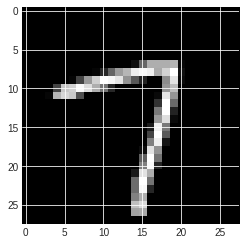

In [93]:
#随机查看测试集表现
test_index = np.random.randint(1000)
show_test(test_index)
predict_result = net.forward(test_img[test_index])
print("predict:{}".format(predict_result.argmax()))

# 网络参数可视化

In [186]:
#定义绘图函数
def param_show(img,i,layer,dimen):
    img = Image.fromarray(np.uint8(img))
    ax = plt.subplot(2,5,i)
    plt.imshow(img, cmap='gray')  # 转化成灰度显示
    ax.set_title(layer+','+'Dimemsion'+str(dimen))

<Figure size 432x288 with 0 Axes>

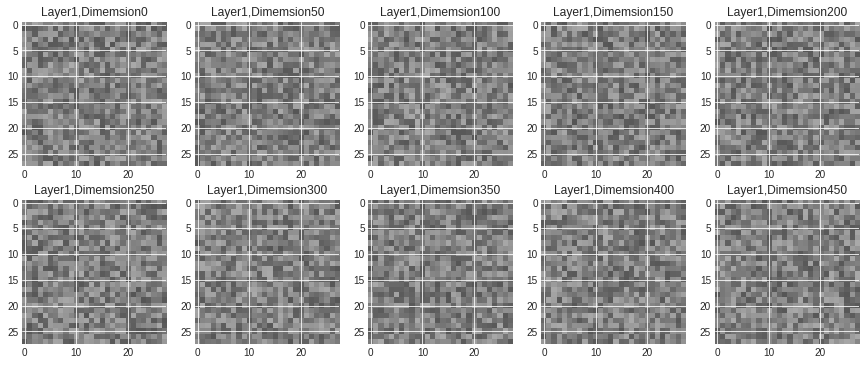

In [192]:
#第一层网络参数可视化，由于第一层共512维，难以全部可视化，抽取10个维度画图。
plt.clf()
plt.figure(figsize = (15,6))
for i in range(10):
    vec = param[1]['w'][:,50*i]
    vec = vec.reshape(28,28)
    vec = vec * 255 + 128
    param_show(vec,i+1,'Layer1',50*i)
plt.savefig('visualofLayer1.png',dpi = 200)

<Figure size 432x288 with 0 Axes>

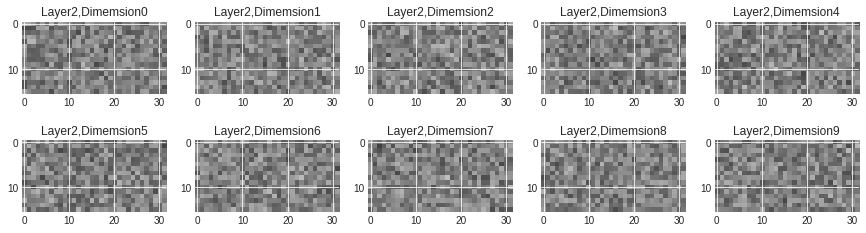

In [196]:
#第二层网络参数可视化，共10个维度。
plt.clf()
plt.figure(figsize = (15,4))
for i in range(10):
    vec = param[2]['w'][:,i]
    vec = vec.reshape(16,32)
    vec = vec * 255 + 128
    param_show(vec,i+1,'Layer2',i)
plt.savefig('visualofLayer2.png',dpi = 200)